In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import py_wake
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import math

from py_wake.wind_farm_models import All2AllIterative
from py_wake.wind_farm_models import PropagateDownwind
from py_wake.deficit_models.deficit_model import WakeDeficitModel, BlockageDeficitModel
from py_wake.deficit_models.no_wake import NoWakeDeficit
from py_wake.site._site import UniformSite
from py_wake.flow_map import XYGrid
from py_wake.flow_map import XZGrid
from py_wake.flow_map import YZGrid
from py_wake.turbulence_models import CrespoHernandez
from py_wake.turbulence_models import GCLTurbulence
from py_wake.deficit_models import Rathmann
from py_wake.utils.plotting import setup_plot

from py_wake.site import UniformWeibullSite

from py_wake.wind_turbines import WindTurbine, WindTurbines
from py_wake.wind_turbines.power_ct_functions import PowerCtTabular
from py_wake.wind_turbines.generic_wind_turbines import GenericWindTurbine

from py_wake.deficit_models.gaussian import BlondelSuperGaussianDeficit2020
from py_wake.literature.gaussian_models import Blondel_Cathelain_2020

In [2]:
optimized_params_05deg=np.loadtxt('107_helix_0.5deg_params_newpow.txt')
optimized_params_1deg=np.loadtxt('102_helix_1deg_params_newpow.txt')
optimized_params_2deg=np.loadtxt('103_helix_2deg_params_newpow.txt')
optimized_params_3deg=np.loadtxt('104_helix_3deg_params_newpow2.txt')
optimized_params_4deg=np.loadtxt('105_helix_4deg_params_newpow3.txt')
optimized_params_5deg=np.loadtxt('106_helix_5deg_params_newpow2.txt')
optimized_params_15deg=np.loadtxt('108_helix_1.5deg_params_newpow.txt')
optimized_params_25deg=np.loadtxt('109_helix_2.5deg_params_newpow.txt')
optimized_params_45deg=np.loadtxt('111_helix_4.5deg_params_newpow.txt')

In [4]:
#turbine parameters
D = 283.21 #rotor diameter
H=170 #hub height
Prated=22000 #kW

WD=270  #wind direction
WS=9 #wind speed
YD=0   #yaw direction
TI=0   #turbulence intensity


#site
site= UniformWeibullSite(p_wd=[0.03597152, 0.03948682, 0.05167394999999999, 0.07000154, 0.08364547,0.0643485,0.08643194,0.1177051,0.1515757, 0.14737920000000002, 0.1001205 , 0.1001205],  # sector frequencies
                               a=[9.176929, 9.782334, 9.531809,9.909545, 10.04269, 9.593921, 9.584007, 10.51499, 11.39895, 11.68746,11.63732,10.08803],          # Weibull scale parameter
                               k=[ 2.392578,2.447266,2.412109,2.591797, 2.755859, 2.595703, 2.583984,2.548828, 2.470703,2.607422, 2.626953, 2.326172],          # Weibull shape parameter
                               ti=TI                          # turbulence intensity, optional
                               )


from wind_turbine_object import create_wind_turbine 



def get_velocity_field_xy(model=None, grid=XYGrid(x=np.linspace(0, 4400, 440), y=np.linspace(-1400 ,1400, 280), h=H),windTurbines=None):
    wfm = All2AllIterative(site, windTurbines, wake_deficitModel=model,blockage_deficitModel=Rathmann(), turbulenceModel=GCLTurbulence())
    result = wfm(x=[0], y=[0], wd=WD, ws=WS, yaw=YD).flow_map(grid)
    return result.WS_eff.values.squeeze()

def get_ct(windTurbines, velocity):
    wf_model2=Blondel_Cathelain_2020(site,windTurbines,turbulenceModel=GCLTurbulence())
    sim_res = wf_model2(x=[0], y=[0],     # wind turbine positions
                   h=H,   # wind turbine heights (defaults to the heights defined in windTurbines)
                   type=0,   # Wind turbine types
                   wd=WD,  # Wind direction
                   ws=velocity,  # Wind speed
                  )
    CT=sim_res.CT.values.squeeze()
    return CT

def get_power(windTurbines,velocity):
    wf_model2=Blondel_Cathelain_2020(site,windTurbines,turbulenceModel=GCLTurbulence())
    sim_res = wf_model2(x=[0], y=[0],     # wind turbine positions
                   h=H,   # wind turbine heights (defaults to the heights defined in windTurbines)
                   type=0,   # Wind turbine types
                   wd=WD,  # Wind direction
                   ws=velocity,  # Wind speed
                  )
    power=sim_res.Power.sel(ws=velocity,wt=0, wd=WD).sum().values/1e6
    return power





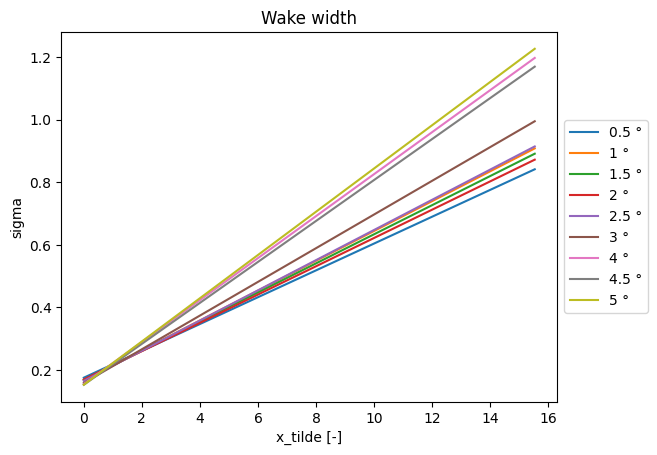

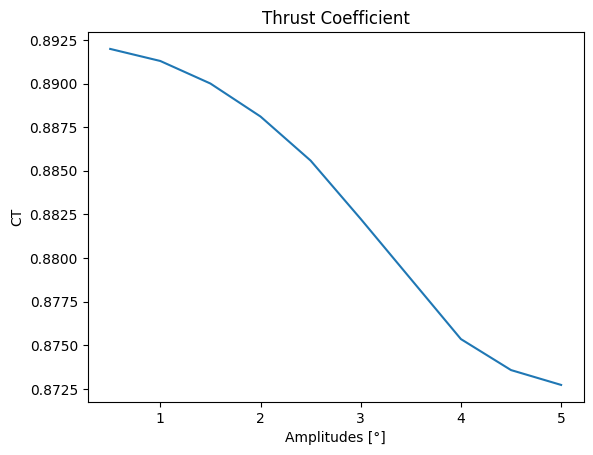

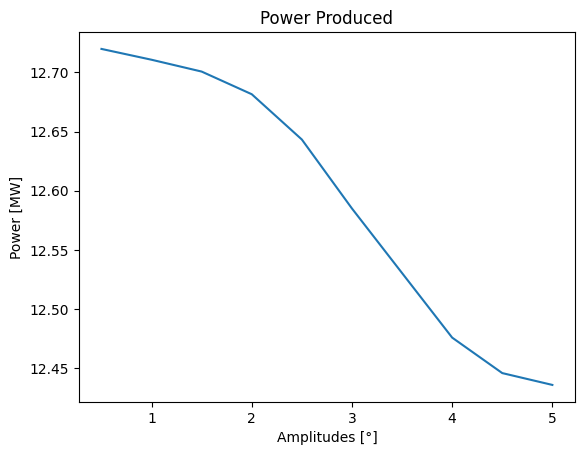

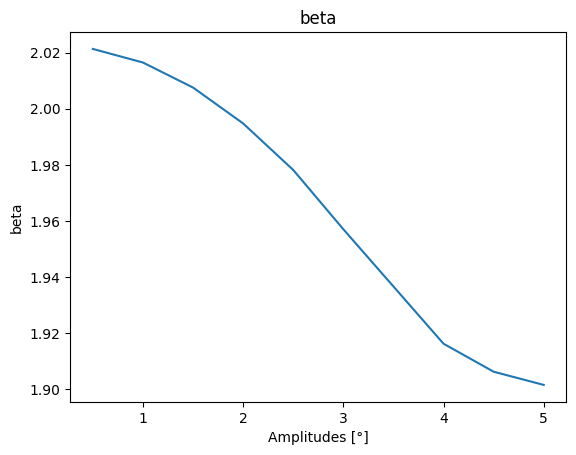

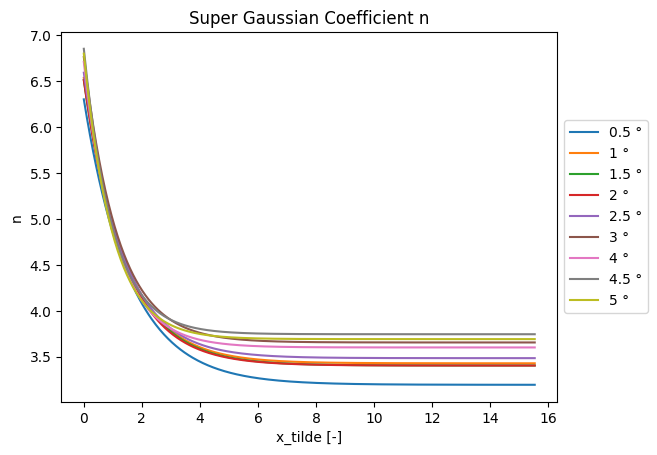

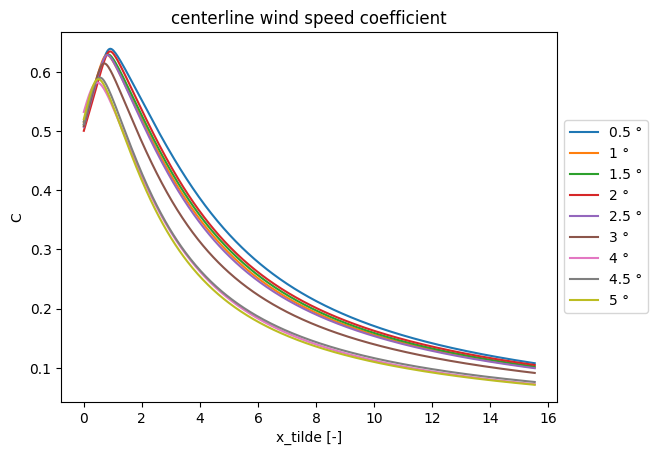

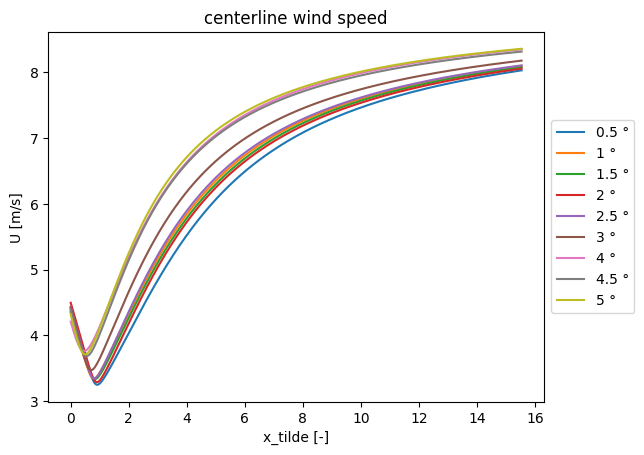

In [6]:
x_tilde=1/D * np.linspace(0, 4400, 440)
x_tilde_matrix = np.tile(x_tilde, (280, 1))


amplitude=0.5
windTurbines = create_wind_turbine(amplitude, D, H)
CT05=get_ct(windTurbines,WS)
POW05=get_power(windTurbines,WS)
beta05=0.5 * (1+np.sqrt(1-CT05))/(np.sqrt(1-CT05))
sigma_05= optimized_params_05deg[0]*x_tilde_matrix[0]+optimized_params_05deg[1]*np.sqrt(beta05)

amplitude=1
windTurbines = create_wind_turbine(amplitude, D, H)
CT1=get_ct(windTurbines,WS)
POW1=get_power(windTurbines,WS)
beta1=0.5 * (1+np.sqrt(1-CT1))/(np.sqrt(1-CT1))
sigma_1= optimized_params_1deg[0]*x_tilde_matrix[0]+optimized_params_1deg[1]*np.sqrt(beta1)

amplitude=1.5
windTurbines = create_wind_turbine(amplitude, D, H)
CT15=get_ct(windTurbines,WS)
POW15=get_power(windTurbines,WS)
beta15=0.5 * (1+np.sqrt(1-CT15))/(np.sqrt(1-CT15))
sigma_15= optimized_params_15deg[0]*x_tilde_matrix[0]+optimized_params_15deg[1]*np.sqrt(beta15)


amplitude=2
windTurbines = create_wind_turbine(amplitude, D, H)
CT2=get_ct(windTurbines,WS)
POW2=get_power(windTurbines,WS)
beta2=0.5 * (1+np.sqrt(1-CT2))/(np.sqrt(1-CT2))
sigma_2= optimized_params_2deg[0]*x_tilde_matrix[0]+optimized_params_2deg[1]*np.sqrt(beta2)

amplitude=2.5
windTurbines = create_wind_turbine(amplitude, D, H)
CT25=get_ct(windTurbines,WS)
POW25=get_power(windTurbines,WS)
beta25=0.5 * (1+np.sqrt(1-CT25))/(np.sqrt(1-CT25))
sigma_25= optimized_params_25deg[0]*x_tilde_matrix[0]+optimized_params_25deg[1]*np.sqrt(beta25)


amplitude=3
windTurbines = create_wind_turbine(amplitude, D, H)
CT3=get_ct(windTurbines,WS)
POW3=get_power(windTurbines,WS)
beta3=0.5 * (1+np.sqrt(1-CT3))/(np.sqrt(1-CT3))
sigma_3= optimized_params_3deg[0]*x_tilde_matrix[0]+optimized_params_3deg[1]*np.sqrt(beta3)


amplitude=4
windTurbines = create_wind_turbine(amplitude, D, H)
CT4=get_ct(windTurbines,WS)
POW4=get_power(windTurbines,WS)
beta4=0.5 * (1+np.sqrt(1-CT4))/(np.sqrt(1-CT4))
sigma_4= optimized_params_4deg[0]*x_tilde_matrix[0]+optimized_params_4deg[1]*np.sqrt(beta4)


amplitude=4.5
windTurbines = create_wind_turbine(amplitude, D, H)
CT45=get_ct(windTurbines,WS)
POW45=get_power(windTurbines,WS)
beta45=0.5 * (1+np.sqrt(1-CT45))/(np.sqrt(1-CT45))
sigma_45= optimized_params_45deg[0]*x_tilde_matrix[0]+optimized_params_45deg[1]*np.sqrt(beta45)

amplitude=5
windTurbines = create_wind_turbine(amplitude, D, H)
CT5=get_ct(windTurbines,WS)
POW5=get_power(windTurbines,WS)
beta5=0.5 * (1+np.sqrt(1-CT5))/(np.sqrt(1-CT5))
sigma_5= optimized_params_5deg[0]*x_tilde_matrix[0]+optimized_params_5deg[1]*np.sqrt(beta5)

plt.plot(x_tilde_matrix[0], sigma_05,label='0.5 °')
plt.plot(x_tilde_matrix[0], sigma_1,label='1 °')
plt.plot(x_tilde_matrix[0], sigma_15,label='1.5 °')
plt.plot(x_tilde_matrix[0], sigma_2,label='2 °')
plt.plot(x_tilde_matrix[0], sigma_25,label='2.5 °')
plt.plot(x_tilde_matrix[0], sigma_3,label='3 °')
plt.plot(x_tilde_matrix[0], sigma_4,label='4 °')
plt.plot(x_tilde_matrix[0], sigma_45,label='4.5 °')
plt.plot(x_tilde_matrix[0], sigma_5,label='5 °')
plt.xlabel('x_tilde [-]')
plt.ylabel('sigma')
plt.title('Wake width')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.plot([0.5,1,1.5,2,2.5,3,4,4.5,5], [CT05,CT1,CT15,CT2,CT25,CT3,CT4,CT45,CT5])
plt.xlabel('Amplitudes [°]')
plt.ylabel('CT')
plt.title('Thrust Coefficient')
plt.show()

plt.plot([0.5,1,1.5,2,2.5,3,4,4.5,5], [POW05,POW1,POW15,POW2,POW25,POW3,POW4,POW45,POW5])
plt.xlabel('Amplitudes [°]')
plt.ylabel('Power [MW]')
plt.title('Power Produced')
plt.show()
 
plt.plot([0.5,1,1.5,2,2.5,3,4,4.5,5], [beta05,beta1,beta15,beta2,beta25,beta3,beta4,beta45,beta5])
plt.xlabel('Amplitudes [°]')
plt.ylabel('beta')
plt.title('beta')
plt.show()

n05=3.11*np.exp(optimized_params_05deg[2]*x_tilde_matrix[0])+optimized_params_05deg[3]
n1=3.11*np.exp(optimized_params_1deg[2]*x_tilde_matrix[0])+optimized_params_1deg[3]
n15=3.11*np.exp(optimized_params_15deg[2]*x_tilde_matrix[0])+optimized_params_15deg[3]
n2=3.11*np.exp(optimized_params_2deg[2]*x_tilde_matrix[0])+optimized_params_2deg[3]
n25=3.11*np.exp(optimized_params_25deg[2]*x_tilde_matrix[0])+optimized_params_25deg[3]
n3=3.11*np.exp(optimized_params_3deg[2]*x_tilde_matrix[0])+optimized_params_3deg[3]
n4=3.11*np.exp(optimized_params_4deg[2]*x_tilde_matrix[0])+optimized_params_4deg[3]
n45=3.11*np.exp(optimized_params_45deg[2]*x_tilde_matrix[0])+optimized_params_45deg[3]
n5=3.11*np.exp(optimized_params_5deg[2]*x_tilde_matrix[0])+optimized_params_5deg[3]
plt.plot(x_tilde_matrix[0], n05,label='0.5 °')
plt.plot(x_tilde_matrix[0], n1,label='1 °')
plt.plot(x_tilde_matrix[0], n15,label='1.5 °')
plt.plot(x_tilde_matrix[0], n2,label='2 °')
plt.plot(x_tilde_matrix[0], n25,label='2.5 °')
plt.plot(x_tilde_matrix[0], n3,label='3 °')
plt.plot(x_tilde_matrix[0], n4,label='4 °')
plt.plot(x_tilde_matrix[0], n45,label='4.5 °')
plt.plot(x_tilde_matrix[0], n5,label='5 °')
plt.xlabel('x_tilde [-]')
plt.ylabel('n')
plt.title('Super Gaussian Coefficient n')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

from autograd.scipy.special import gamma as agamma
C05=2**(2/n05-1)-np.sqrt(2**(4/n05-2)-(n05*CT05)/(16*agamma(2/n05)*np.sign(sigma_05)*np.abs(sigma_05)**(4/n05)))
C1=2**(2/n1-1)-np.sqrt(2**(4/n1-2)-(n1*CT1)/(16*agamma(2/n1)*np.sign(sigma_1)*np.abs(sigma_1)**(4/n1)))
C15=2**(2/n15-1)-np.sqrt(2**(4/n15-2)-(n15*CT15)/(16*agamma(2/n15)*np.sign(sigma_15)*np.abs(sigma_15)**(4/n15)))
C2=2**(2/n2-1)-np.sqrt(2**(4/n2-2)-(n2*CT2)/(16*agamma(2/n2)*np.sign(sigma_2)*np.abs(sigma_2)**(4/n2)))
C25=2**(2/n25-1)-np.sqrt(2**(4/n25-2)-(n25*CT25)/(16*agamma(2/n25)*np.sign(sigma_25)*np.abs(sigma_25)**(4/n25)))
C3=2**(2/n3-1)-np.sqrt(2**(4/n3-2)-(n3*CT3)/(16*agamma(2/n3)*np.sign(sigma_3)*np.abs(sigma_3)**(4/n3)))
C4=2**(2/n4-1)-np.sqrt(2**(4/n4-2)-(n4*CT4)/(16*agamma(2/n4)*np.sign(sigma_4)*np.abs(sigma_4)**(4/n4)))
C45=2**(2/n45-1)-np.sqrt(2**(4/n45-2)-(n45*CT45)/(16*agamma(2/n45)*np.sign(sigma_45)*np.abs(sigma_45)**(4/n45)))
C5=2**(2/n5-1)-np.sqrt(2**(4/n5-2)-(n5*CT5)/(16*agamma(2/n5)*np.sign(sigma_5)*np.abs(sigma_5)**(4/n5)))
plt.plot(x_tilde_matrix[0], C05,label='0.5 °')
plt.plot(x_tilde_matrix[0], C1,label='1 °')
plt.plot(x_tilde_matrix[0], C15,label='1.5 °')
plt.plot(x_tilde_matrix[0], C2,label='2 °')
plt.plot(x_tilde_matrix[0], C25,label='2.5 °')
plt.plot(x_tilde_matrix[0], C3,label='3 °')
plt.plot(x_tilde_matrix[0], C4,label='4 °')
plt.plot(x_tilde_matrix[0], C45,label='4.5 °')
plt.plot(x_tilde_matrix[0], C5,label='5 °')
plt.xlabel('x_tilde [-]')
plt.ylabel('C')
plt.title('centerline wind speed coefficient')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()

W05=9-9*C05
W1=9-9*C1
W15=9-9*C15
W2=9-9*C2
W25=9-9*C25
W3=9-9*C3
W4=9-9*C4
W45=9-9*C45
W5=9-9*C5
plt.plot(x_tilde_matrix[0], W05,label='0.5 °')
plt.plot(x_tilde_matrix[0], W1,label='1 °')
plt.plot(x_tilde_matrix[0], W15,label='1.5 °')
plt.plot(x_tilde_matrix[0], W2,label='2 °')
plt.plot(x_tilde_matrix[0], W25,label='2.5 °')
plt.plot(x_tilde_matrix[0], W3,label='3 °')
plt.plot(x_tilde_matrix[0], W4,label='4 °')
plt.plot(x_tilde_matrix[0], W45,label='4.5 °')
plt.plot(x_tilde_matrix[0], W5,label='5 °')
plt.xlabel('x_tilde [-]')
plt.ylabel('U [m/s]')
plt.title('centerline wind speed')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()



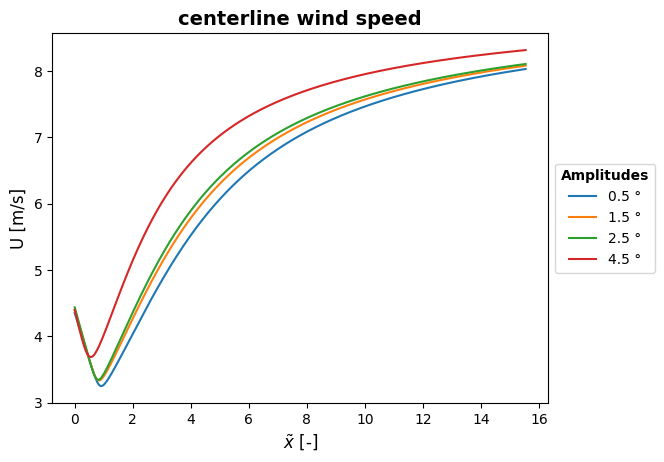

In [21]:
plt.plot(x_tilde_matrix[0], W05,label='0.5 °')

plt.plot(x_tilde_matrix[0], W15,label='1.5 °')

plt.plot(x_tilde_matrix[0], W25,label='2.5 °')

plt.plot(x_tilde_matrix[0], W45,label='4.5 °')

plt.xlabel(r'$\tilde{x}$ [-]',fontsize=12)
plt.ylabel('U [m/s]',fontsize=12)
plt.title('centerline wind speed',fontsize=14 ,fontweight='bold')

legend = plt.legend(title='Amplitudes', loc='center left', bbox_to_anchor=(1, 0.5))
plt.setp(legend.get_title(), fontsize='medium', fontweight='bold')

plt.show()

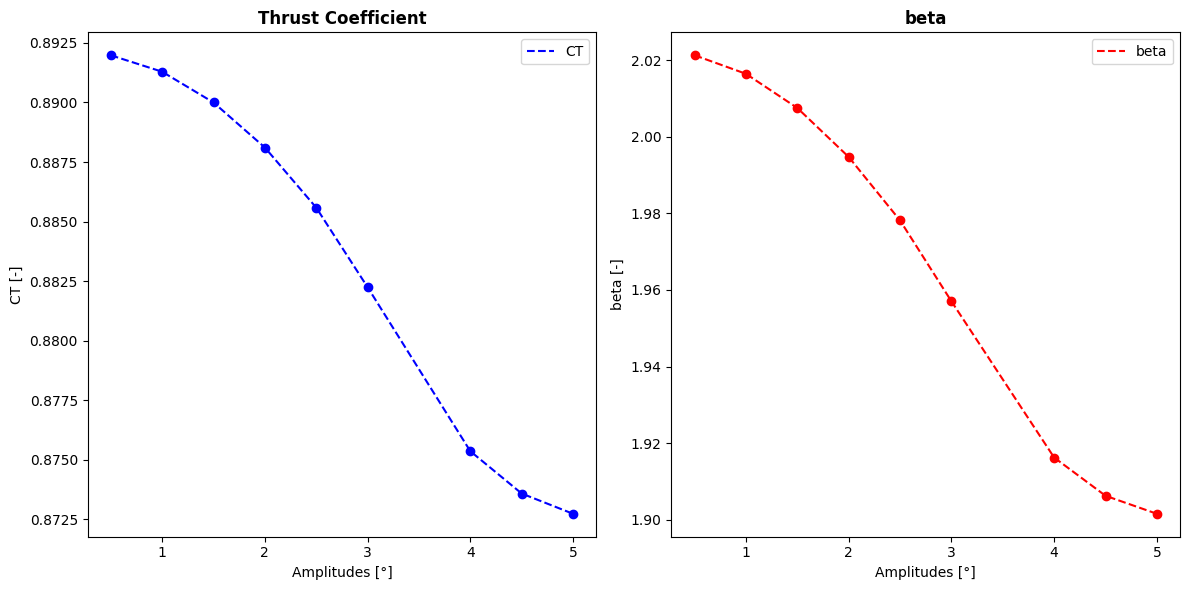

In [6]:
import matplotlib.pyplot as plt

# Data
amplitudes = [0.5, 1, 1.5, 2, 2.5, 3, 4, 4.5, 5]
CT = [CT05, CT1, CT15, CT2, CT25, CT3, CT4, CT45, CT5]
beta = [beta05, beta1, beta15, beta2, beta25, beta3, beta4, beta45, beta5]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot for Thrust Coefficient (CT)
ax1.plot(amplitudes, CT, 'b--', label='CT')
ax1.scatter(amplitudes, CT, color='b')
ax1.set_xlabel('Amplitudes [°]')
ax1.set_ylabel('CT [-]')
ax1.set_title('Thrust Coefficient', fontweight='bold')
ax1.legend()

# Plot for beta
ax2.plot(amplitudes, beta, 'r--', label='beta')
ax2.scatter(amplitudes, beta, color='r')
ax2.set_xlabel('Amplitudes [°]')
ax2.set_ylabel('beta [-]')
ax2.set_title('beta', fontweight='bold')
ax2.legend()

# Adjust layout
plt.tight_layout()
plt.show()


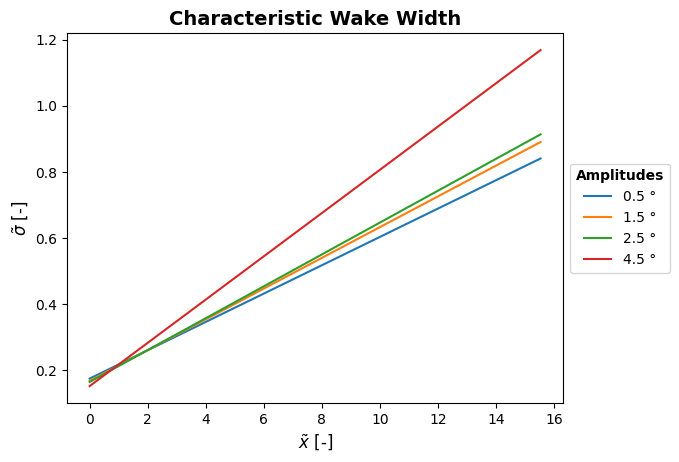

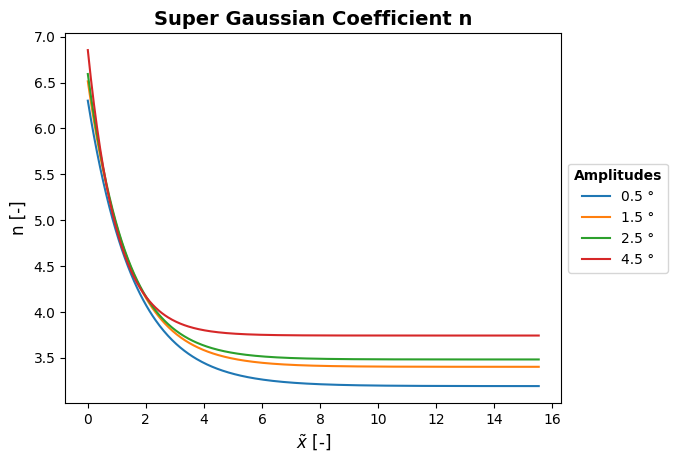

In [8]:
x_tilde = x_tilde_matrix[0]
plt.plot(x_tilde, sigma_05, label='0.5 °')
plt.plot(x_tilde, sigma_15, label='1.5 °')
plt.plot(x_tilde, sigma_25, label='2.5 °')
plt.plot(x_tilde, sigma_45, label='4.5 °')
plt.xlabel(r'$\tilde{x}$ [-]',fontsize=12)
plt.ylabel(r'$\tilde{\sigma}$ [-]',fontsize=12)
plt.title('Characteristic Wake Width',fontsize=14, fontweight='bold')
legend = plt.legend(title='Amplitudes', loc='center left', bbox_to_anchor=(1, 0.5))
plt.setp(legend.get_title(), fontsize='medium', fontweight='bold')
output_path = r'C:\Users\asus\Desktop\Delft\THESIS\REPORT\IMAGES REPORT\7_sigma.png'
plt.savefig(output_path, bbox_inches='tight')
plt.show()

  
plt.plot(x_tilde, n05,label='0.5 °')
plt.plot(x_tilde, n15,label='1.5 °')
plt.plot(x_tilde, n25,label='2.5 °')
plt.plot(x_tilde, n45,label='4.5 °')
plt.xlabel(r'$\tilde{x}$ [-]',fontsize=12)
plt.ylabel('n [-]',fontsize=12)
plt.title('Super Gaussian Coefficient n',fontsize=14, fontweight='bold')
legend = plt.legend(title='Amplitudes', loc='center left', bbox_to_anchor=(1, 0.5))
plt.setp(legend.get_title(), fontsize='medium', fontweight='bold')
output_path = r'C:\Users\asus\Desktop\Delft\THESIS\REPORT\IMAGES REPORT\7_n_coefficient.png'
plt.savefig(output_path, bbox_inches='tight')
plt.show()

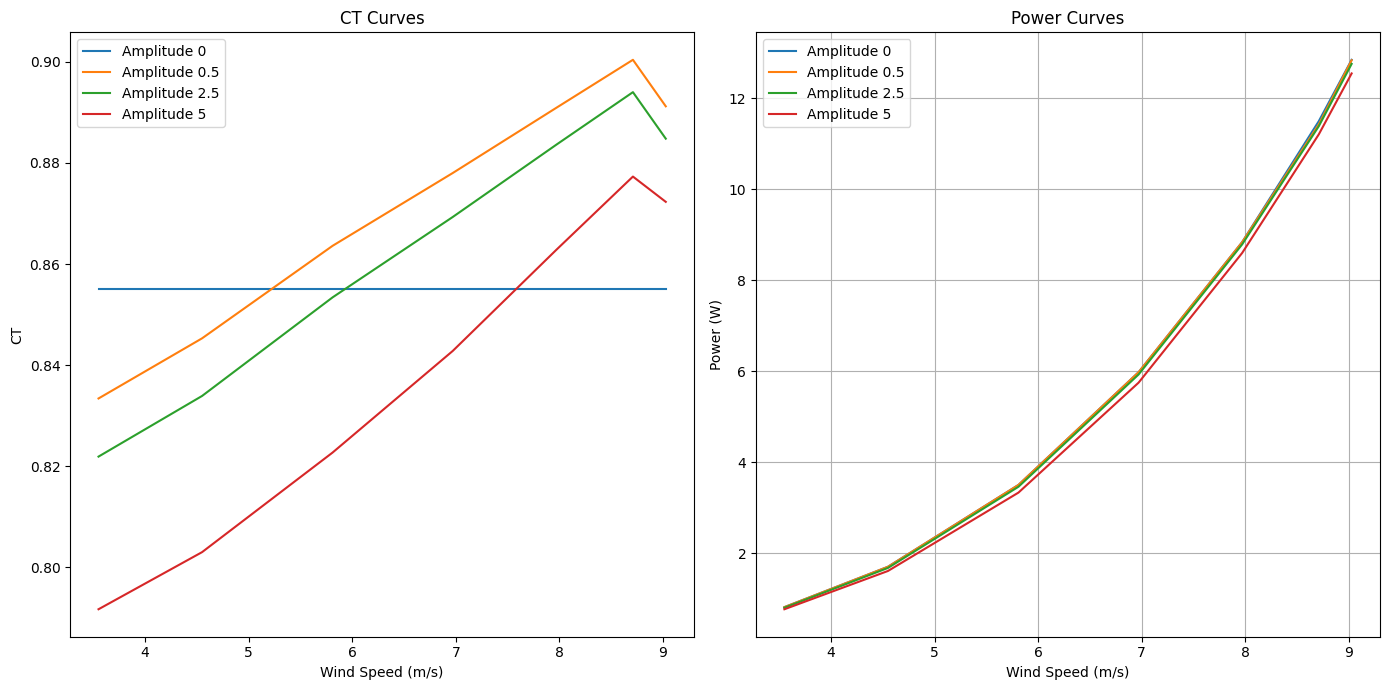

In [7]:


wind_speeds=[3.55,4.55,5.81,6.97,7.97,8.71,9.027]
amplitudes = [ 0,0.5,2.5,5]
# Data structures to store CT and power values
ct_values = {amplitude: [] for amplitude in amplitudes}
power_values = {amplitude: [] for amplitude in amplitudes}

# Nested loops to calculate CT and power for each combination
for speed in wind_speeds:
    for amplitude in amplitudes:
        windTurbine = create_wind_turbine(amplitude, D, H)
        CT = get_ct(windTurbine, speed)
        POW = get_power(windTurbine, speed)
        ct_values[amplitude].append(CT)
        power_values[amplitude].append(POW)

# Plotting the results
plt.figure(figsize=(14, 7))

# Plot CT curves
plt.subplot(1, 2, 1)
for amplitude in amplitudes:
    plt.plot(wind_speeds, ct_values[amplitude], label=f'Amplitude {amplitude}')
plt.title('CT Curves')
plt.xlabel('Wind Speed (m/s)')
plt.ylabel('CT')
plt.legend()

# Plot power curves
plt.subplot(1, 2, 2)
for amplitude in amplitudes:
    plt.plot(wind_speeds, power_values[amplitude], label=f'Amplitude {amplitude}')
plt.title('Power Curves')
plt.xlabel('Wind Speed (m/s)')
plt.ylabel('Power (W)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


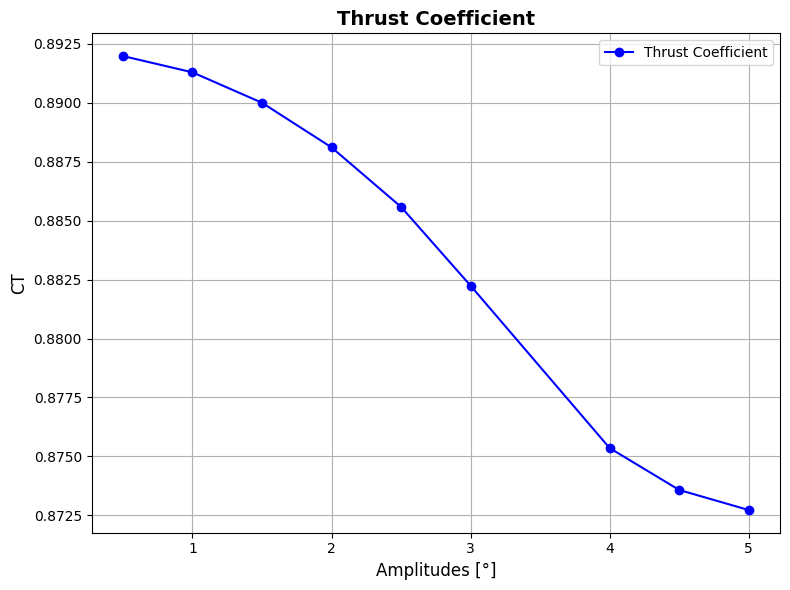

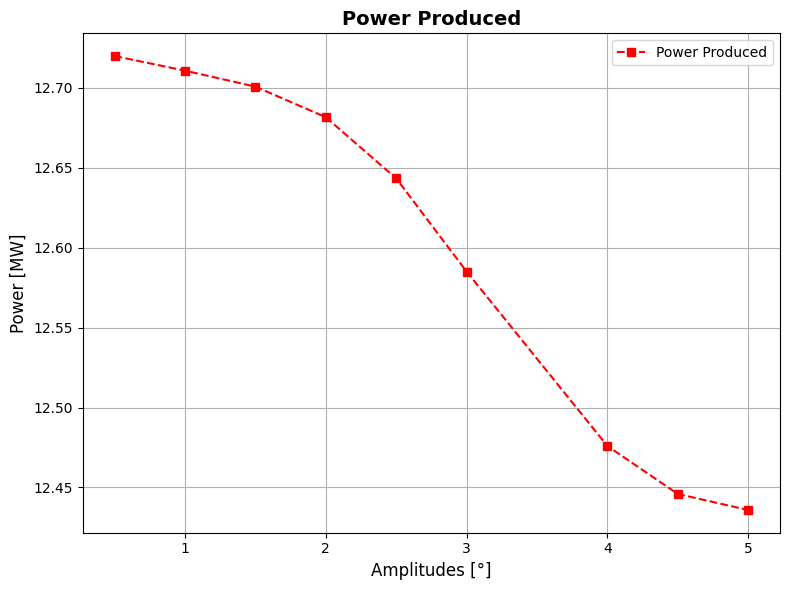

In [7]:
import matplotlib.pyplot as plt

# Example data
amplitudes = [0.5, 1, 1.5, 2, 2.5, 3, 4, 4.5, 5]
thrust_coefficient = [CT05, CT1, CT15, CT2, CT25, CT3, CT4, CT45, CT5]
power_produced = [POW05, POW1, POW15, POW2, POW25, POW3, POW4, POW45, POW5]

# Plot Thrust Coefficient
plt.figure(figsize=(8, 6))
plt.plot(amplitudes, thrust_coefficient, marker='o', linestyle='-', color='b', label='Thrust Coefficient')
plt.xlabel('Amplitudes [°]', fontsize=12)
plt.ylabel('CT', fontsize=12)
plt.title('Thrust Coefficient', fontsize=14, fontweight='bold')
plt.grid(True)
plt.legend()
plt.tight_layout()
output_path = r'C:\Users\asus\Desktop\Delft\THESIS\REPORT\IMAGES REPORT\7_CT.png'
plt.savefig(output_path, bbox_inches='tight')
plt.show()

# Plot Power Produced
plt.figure(figsize=(8, 6))
plt.plot(amplitudes, power_produced, marker='s', linestyle='--', color='r', label='Power Produced')
plt.xlabel('Amplitudes [°]', fontsize=12)
plt.ylabel('Power [MW]', fontsize=12)
plt.title('Power Produced', fontsize=14, fontweight='bold')
plt.grid(True)
plt.legend()
plt.tight_layout()
output_path = r'C:\Users\asus\Desktop\Delft\THESIS\REPORT\IMAGES REPORT\7_power.png'
plt.savefig(output_path, bbox_inches='tight')
plt.show()


C:\Users\asus\AppData\Local\Temp\ipykernel_6028\215640253.py:16: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "o-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.errorbar(amplitudes, power, fmt='o-', capsize=5, color='r', linestyle='--', marker='s', label='Power Produced')
C:\Users\asus\AppData\Local\Temp\ipykernel_6028\215640253.py:16: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o-" (-> marker='o'). The keyword argument will take precedence.
  plt.errorbar(amplitudes, power, fmt='o-', capsize=5, color='r', linestyle='--', marker='s', label='Power Produced')


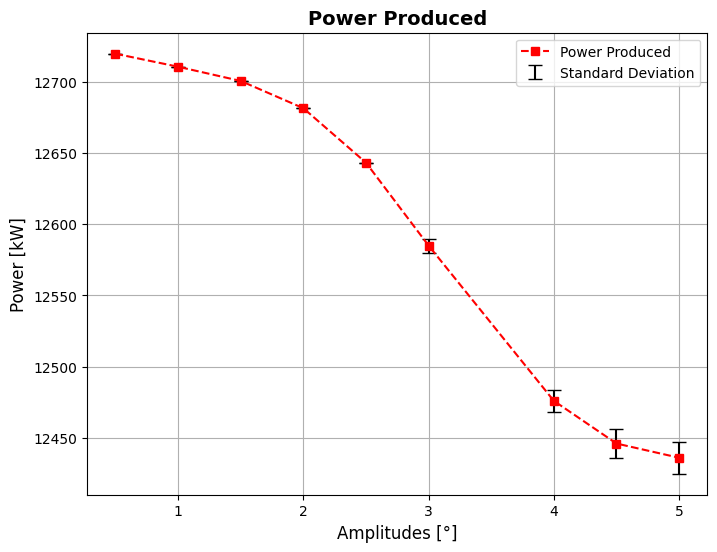

C:\Users\asus\AppData\Local\Temp\ipykernel_6028\215640253.py:29: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "o-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.errorbar(amplitudes, thrust_coefficient, fmt='o-', capsize=5, color='b', linestyle='--', marker='s', label='Thrust Coefficient')
C:\Users\asus\AppData\Local\Temp\ipykernel_6028\215640253.py:29: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o-" (-> marker='o'). The keyword argument will take precedence.
  plt.errorbar(amplitudes, thrust_coefficient, fmt='o-', capsize=5, color='b', linestyle='--', marker='s', label='Thrust Coefficient')


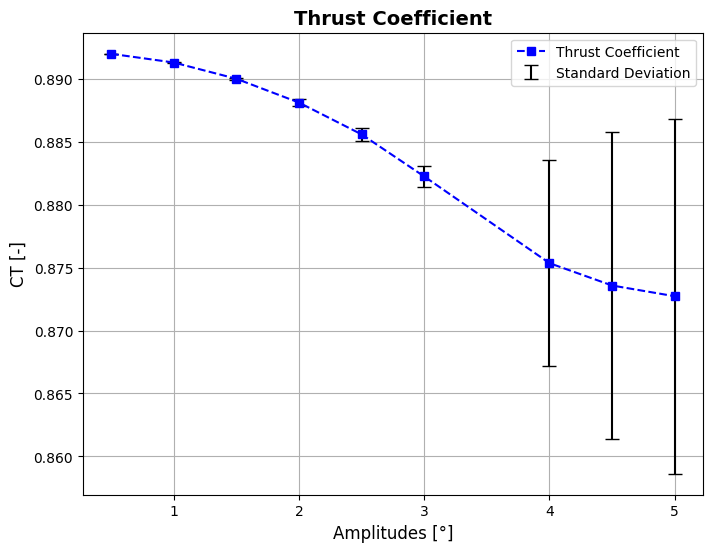

In [22]:
import matplotlib.pyplot as plt

# Amplitudes
amplitudes = [0.5, 1, 1.5, 2, 2.5, 3, 4, 4.5, 5]

# Mean power values
power =  [POW05*1000, POW1*1000, POW15*1000, POW2*1000, POW25*1000, POW3*1000, POW4*1000, POW45*1000, POW5*1000] 
thrust_coefficient = [CT05, CT1, CT15, CT2, CT25, CT3, CT4, CT45, CT5]

# Standard deviations
std_dev_pow = [0, 0, 0, 0, 0, 4.97, 7.5, 10.11, 11.23]
std_dev_ct =  [ 6.6 *10**(-6) ,7.6* 10**(-5) ,0.0001, 0.0003, 0.0005 ,0.0008, 0.0082, 0.0122 ,0.0141 ]

# Create the plot
plt.figure(figsize=(8, 6))
plt.errorbar(amplitudes, power, fmt='o-', capsize=5, color='r', linestyle='--', marker='s', label='Power Produced')
plt.errorbar(amplitudes, power, yerr=std_dev_pow, fmt='none', ecolor='k', capsize=5, label='Standard Deviation')
plt.xlabel('Amplitudes [°]', fontsize=12)
plt.ylabel('Power [kW]', fontsize=12)
plt.title('Power Produced', fontsize=14, fontweight='bold')
plt.grid(True)
plt.legend()
output_path = r'C:\Users\asus\Desktop\Delft\THESIS\REPORT\IMAGES REPORT\7_power.png'
plt.savefig(output_path, bbox_inches='tight')
plt.show()

# Create the plot
plt.figure(figsize=(8, 6))
plt.errorbar(amplitudes, thrust_coefficient, fmt='o-', capsize=5, color='b', linestyle='--', marker='s', label='Thrust Coefficient')
plt.errorbar(amplitudes, thrust_coefficient, yerr=std_dev_ct, fmt='none', ecolor='k', capsize=5, label='Standard Deviation')
plt.xlabel('Amplitudes [°]', fontsize=12)
plt.ylabel('CT [-]', fontsize=12)
plt.title('Thrust Coefficient', fontsize=14, fontweight='bold')
plt.grid(True)
plt.legend()
output_path = r'C:\Users\asus\Desktop\Delft\THESIS\REPORT\IMAGES REPORT\7_CT.png'
plt.savefig(output_path, bbox_inches='tight')
plt.show()




WIND FLOW FIELD

Parameters: [0, 0.04287642415600248, 0.12299183577293872, -0.62801698669126, 3.192306284292899]


C:\Users\asus\AppData\Local\Temp\ipykernel_22892\2165246276.py:59: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([int(tick) for tick in x_ticks])  # Convert to integer and set as tick labels
C:\Users\asus\AppData\Local\Temp\ipykernel_22892\2165246276.py:60: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([int(tick) for tick in y_ticks])  # Convert to integer and set as tick labels


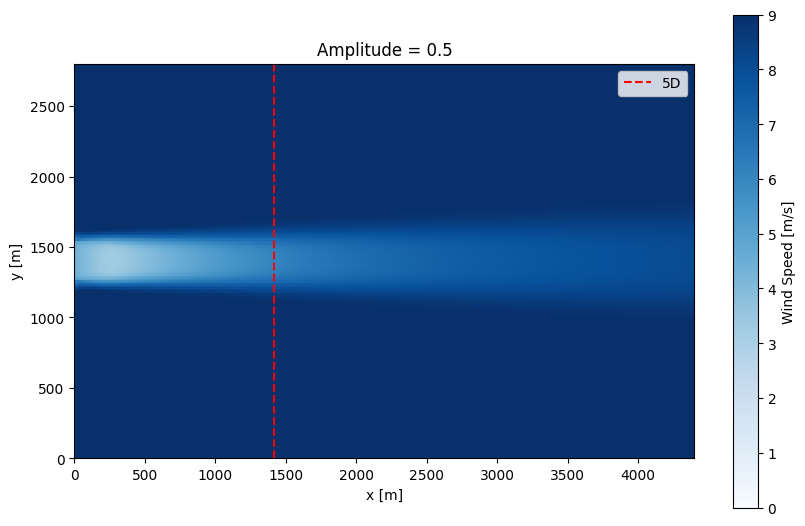

Parameters: [0, 0.04767439580309289, 0.11768320759997446, -0.7193407986114957, 3.4265830147628074]


C:\Users\asus\AppData\Local\Temp\ipykernel_22892\2165246276.py:59: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([int(tick) for tick in x_ticks])  # Convert to integer and set as tick labels
C:\Users\asus\AppData\Local\Temp\ipykernel_22892\2165246276.py:60: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([int(tick) for tick in y_ticks])  # Convert to integer and set as tick labels


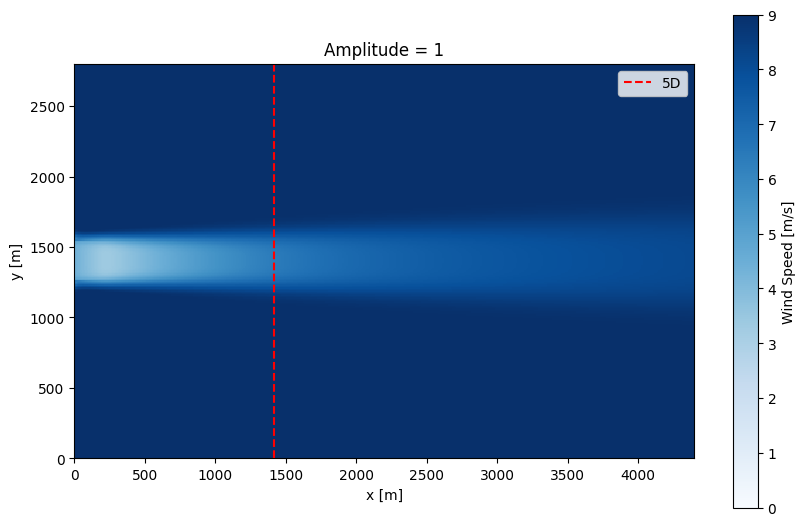

Parameters: [0, 0.046517984569372416, 0.11862557130283828, -0.7103919422868702, 3.4025430546939037]


C:\Users\asus\AppData\Local\Temp\ipykernel_22892\2165246276.py:59: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([int(tick) for tick in x_ticks])  # Convert to integer and set as tick labels
C:\Users\asus\AppData\Local\Temp\ipykernel_22892\2165246276.py:60: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([int(tick) for tick in y_ticks])  # Convert to integer and set as tick labels


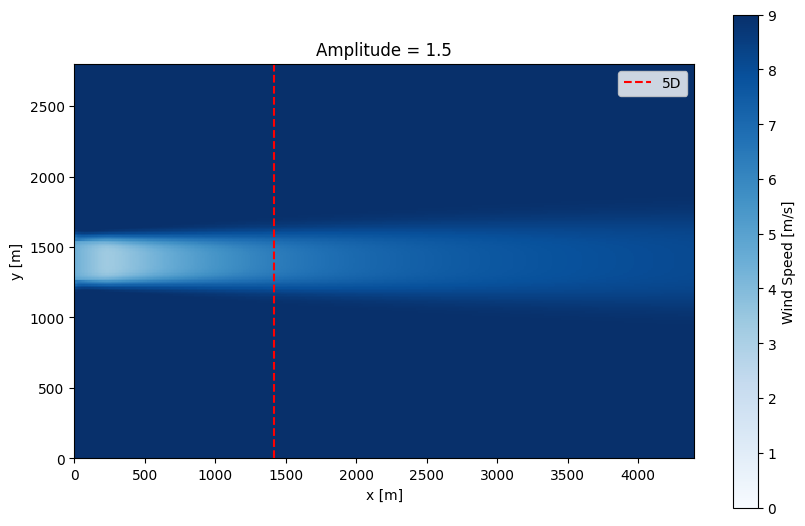

Parameters: [0, 0.04521537650142811, 0.11985987461479489, -0.7240950579519034, 3.401801332653049]


C:\Users\asus\AppData\Local\Temp\ipykernel_22892\2165246276.py:59: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([int(tick) for tick in x_ticks])  # Convert to integer and set as tick labels
C:\Users\asus\AppData\Local\Temp\ipykernel_22892\2165246276.py:60: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([int(tick) for tick in y_ticks])  # Convert to integer and set as tick labels


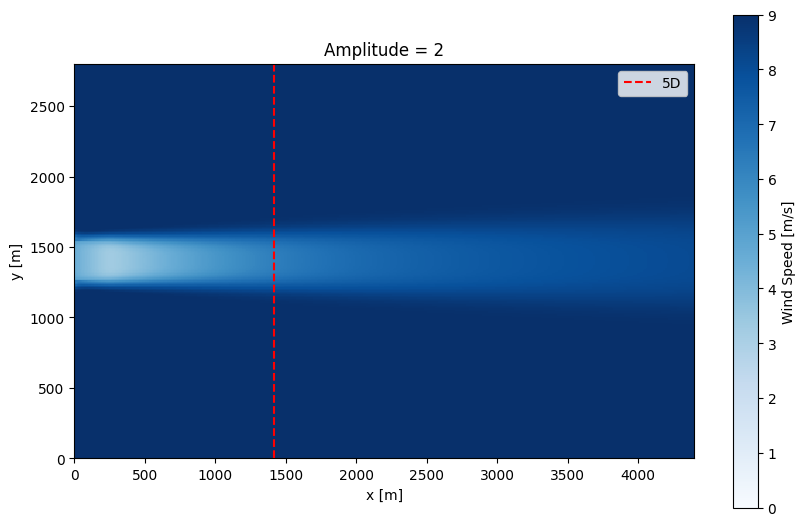

KeyboardInterrupt: 

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import time
D=283.21

# Define the list of amplitudes
amplitudes = [0.5, 1, 1.5, 2, 2.5, 3, 4, 4.5, 5]

# Define optimized_params_list with all amplitudes and their parameters
optimized_params_list = [
    [0, optimized_params_05deg[0], optimized_params_05deg[1], optimized_params_05deg[2], optimized_params_05deg[3]],
    [0, optimized_params_1deg[0], optimized_params_1deg[1], optimized_params_1deg[2], optimized_params_1deg[3]],
    [0, optimized_params_15deg[0], optimized_params_15deg[1], optimized_params_15deg[2], optimized_params_15deg[3]],
    [0, optimized_params_2deg[0], optimized_params_2deg[1], optimized_params_2deg[2], optimized_params_2deg[3]],
    [0, optimized_params_25deg[0], optimized_params_25deg[1], optimized_params_25deg[2], optimized_params_25deg[3]],
    [0, optimized_params_3deg[0], optimized_params_3deg[1], optimized_params_3deg[2], optimized_params_3deg[3]],
    [0, optimized_params_4deg[0], optimized_params_4deg[1], optimized_params_4deg[2], optimized_params_4deg[3]],
    [0, optimized_params_45deg[0], optimized_params_45deg[1], optimized_params_45deg[2], optimized_params_45deg[3]],
    [0, optimized_params_5deg[0], optimized_params_5deg[1], optimized_params_5deg[2], optimized_params_5deg[3]],
]

# Generate the list of velocity fields
velocity_fields = []
for j, amplitude in enumerate(amplitudes):
    params = optimized_params_list[j]
    
    windTurbine = create_wind_turbine(amplitude, D, H)
    model = BlondelSuperGaussianDeficit2020(
        a_s=0, 
        b_s=params[1], 
        c_s=params[2], 
        b_f=params[3], 
        c_f=params[4]
    )
    velocity_field = get_velocity_field_xy(model, windTurbines=windTurbine)
    velocity_fields.append(velocity_field)

# Plot the velocity fields for each amplitude
for j in range(len(velocity_fields)):
    print('Parameters:', optimized_params_list[j])
    fig = plt.figure(figsize=(10, 8))
    
    # Multiply x and y coordinates by 10
    extent = [0, velocity_fields[j].shape[1] * 10, 0, velocity_fields[j].shape[0] * 10]
    
    plt.imshow(velocity_fields[j], cmap='Blues', interpolation='nearest', extent=extent, vmin=0, vmax=WS)
    
    # Add colorbar and label with adjusted size
    cbar = plt.colorbar(shrink=0.8)  # Adjust the shrink parameter to control the size
    cbar.set_label('Wind Speed [m/s]')  # Label for the colorbar
    
    plt.title(f'Amplitude = {amplitudes[j]}')
    
    # Adjust the tick labels
    ax = plt.gca()
    x_ticks = ax.get_xticks()
    y_ticks = ax.get_yticks()
    ax.set_xticklabels([int(tick) for tick in x_ticks])  # Convert to integer and set as tick labels
    ax.set_yticklabels([int(tick) for tick in y_ticks])  # Convert to integer and set as tick labels
    
    # Add vertical red dotted line at 3*D
    plt.axvline(x=5 *D, color='red', linestyle='--', label='5D')
    
    # Add legend
    plt.legend(loc='upper right')
    
    plt.xlabel('x [m]')
    plt.ylabel('y [m]')
    plt.show()
    time.sleep(1)  # Pause for 1 second
    plt.close(fig)

REPRESENTATION (SCATTER PLOT)

In [9]:
amplitudes=[1,4,5,0.5,1.5,2.5]
ks=[optimized_params_1deg[0],optimized_params_4deg[0],optimized_params_5deg[0],optimized_params_05deg[0],optimized_params_15deg[0],optimized_params_25deg[0]]
cs=[optimized_params_1deg[1],optimized_params_4deg[1],optimized_params_5deg[1],optimized_params_05deg[1],optimized_params_15deg[1],optimized_params_25deg[1]]
bf=[optimized_params_1deg[2],optimized_params_4deg[2],optimized_params_5deg[2],optimized_params_05deg[2],optimized_params_15deg[2],optimized_params_25deg[2]]
cf=[optimized_params_1deg[3],optimized_params_4deg[3],optimized_params_5deg[3],optimized_params_05deg[3],optimized_params_15deg[3],optimized_params_25deg[3]]

In [19]:
amplitudes=[1,2,3,4,5,0.5,1.5,2.5,4.5]
ks=[optimized_params_1deg[0],optimized_params_2deg[0],optimized_params_3deg[0],optimized_params_4deg[0],optimized_params_5deg[0],optimized_params_05deg[0],optimized_params_15deg[0],optimized_params_25deg[0],optimized_params_45deg[0]]
cs=[optimized_params_1deg[1],optimized_params_2deg[1],optimized_params_3deg[1],optimized_params_4deg[1],optimized_params_5deg[1],optimized_params_05deg[1],optimized_params_15deg[1],optimized_params_25deg[1],optimized_params_45deg[1]]
bf=[optimized_params_1deg[2],optimized_params_2deg[2],optimized_params_3deg[2],optimized_params_4deg[2],optimized_params_5deg[2],optimized_params_05deg[2],optimized_params_15deg[2],optimized_params_25deg[2],optimized_params_45deg[2]]
cf=[optimized_params_1deg[3],optimized_params_2deg[3],optimized_params_3deg[3],optimized_params_4deg[3],optimized_params_5deg[3],optimized_params_05deg[3],optimized_params_15deg[3],optimized_params_25deg[3],optimized_params_45deg[3]]

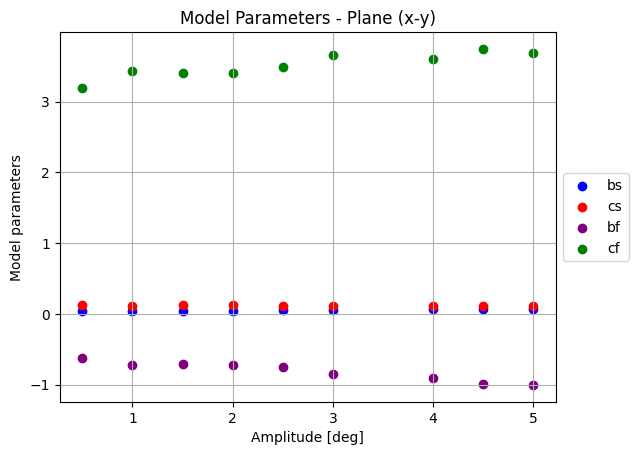

In [20]:
plt.scatter(amplitudes, ks, color='blue', label='bs', marker='o')
plt.scatter(amplitudes, cs, color='red', label='cs', marker='o')
plt.scatter(amplitudes, bf, color='purple', label='bf', marker='o')
plt.scatter(amplitudes, cf, color='green', label='cf', marker='o')


# Add labels and title
plt.xlabel('Amplitude [deg]')
plt.ylabel('Model parameters')
plt.title('Model Parameters - Plane (x-y)')

# Add legend
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.grid(True)
# Display the plot
plt.show()


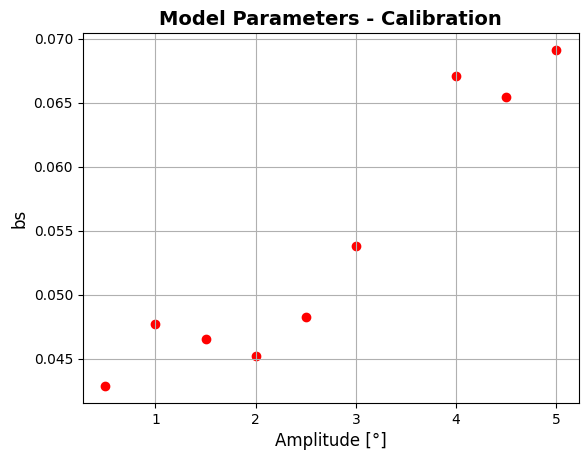

In [21]:
plt.scatter(amplitudes, ks, color='red', label='ks', marker='o')

# Add labels and title
plt.xlabel('Amplitude [°]',fontsize=12)
plt.ylabel('bs',fontsize=12)
plt.title('Model Parameters - Calibration',fontsize=14,fontweight='bold')

# Add grid
plt.grid(True)

# Display the plot
plt.show()


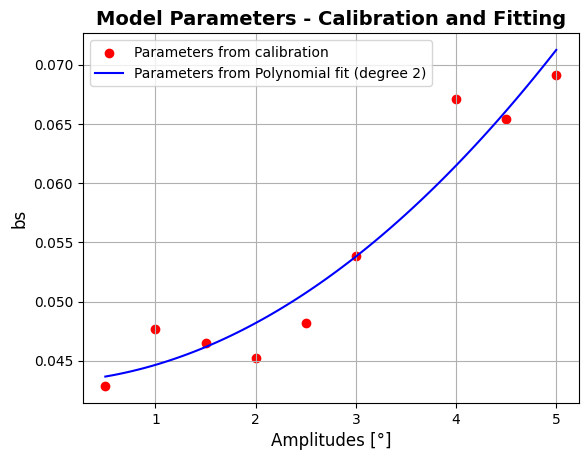

In [22]:
# Fit a polynomial of degree n (e.g., n=2 for a quadratic fit)
x=amplitudes
y=ks

degree = 2
coefficients_bs = np.polyfit(x, y, degree)
np.savetxt('coefficients_bs.txt',coefficients_bs)
# Define the interpolation function

def polynomial_function(coefficients_bs, x):
    degree = len(coefficients_bs) - 1
    f = sum(coef * x**(degree - i) for i, coef in enumerate(coefficients_bs))
    return f

# Generate x values for interpolation
x_interpolated_bs = np.linspace(min(x), max(x), 100)
y_interpolated_bs = polynomial_function(coefficients_bs, x_interpolated_bs)

# Plot the original data points
plt.scatter(x, y, color='red', label='Parameters from calibration')

# Plot the polynomial fit
plt.plot(x_interpolated_bs, y_interpolated_bs, color='blue', label=f'Parameters from Polynomial fit (degree {degree})')

# Add labels and legend
plt.xlabel('Amplitudes [°]',fontsize=12)
plt.ylabel('bs',fontsize=12)
plt.legend()
plt.title('Model Parameters - Calibration and Fitting',fontsize=14,fontweight='bold')
plt.grid(True)
output_path = r'C:\Users\asus\Desktop\Delft\THESIS\REPORT\IMAGES REPORT\7_bs_fit.png'
plt.savefig(output_path, bbox_inches='tight')
plt.show()

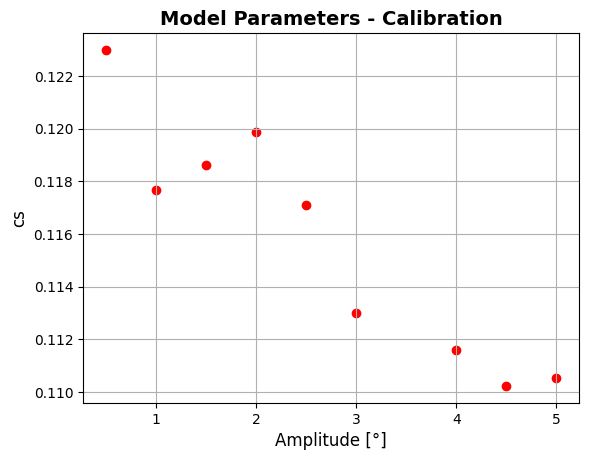

In [24]:
plt.scatter(amplitudes, cs, color='red', label='ks', marker='o')

# Add labels and title
plt.xlabel('Amplitude [°]',fontsize=12)
plt.ylabel('cs',fontsize=12)
plt.title('Model Parameters - Calibration',fontsize=14,fontweight='bold')

# Add grid
plt.grid(True)

# Display the plot
plt.show()



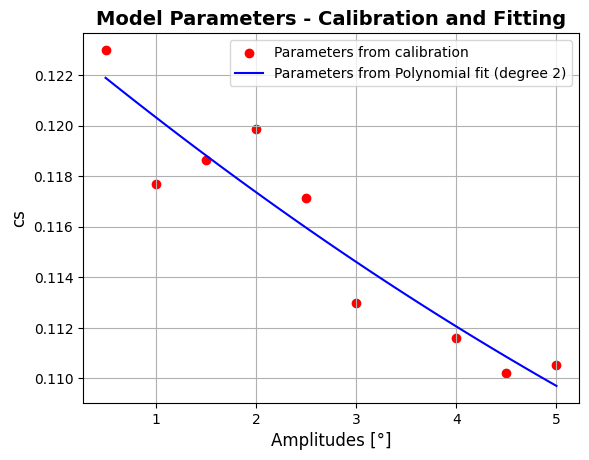

In [25]:
# Fit a polynomial of degree n (e.g., n=2 for a quadratic fit)
x=amplitudes
y=cs

degree = 2
coefficients_cs = np.polyfit(x, y, degree)
np.savetxt('coefficients_cs.txt',coefficients_cs)
# Define the interpolation function
def polynomial_function(coefficients_cs, x):
    degree = len(coefficients_cs) - 1
    f = sum(coef * x**(degree - i) for i, coef in enumerate(coefficients_cs))
    return f

# Generate x values for interpolation
x_interpolated_cs = np.linspace(min(x), max(x), 100)
y_interpolated_cs = polynomial_function(coefficients_cs, x_interpolated_cs)

# Plot the original data points
plt.scatter(x, y, color='red', label='Parameters from calibration')

# Plot the polynomial fit
plt.plot(x_interpolated_cs, y_interpolated_cs, color='blue', label=f'Parameters from Polynomial fit (degree {degree})')

# Add labels and legend
plt.xlabel('Amplitudes [°]',fontsize=12)
plt.ylabel('cs',fontsize=12)
plt.legend()
plt.title('Model Parameters - Calibration and Fitting',fontsize=14,fontweight='bold')
plt.grid(True)
output_path = r'C:\Users\asus\Desktop\Delft\THESIS\REPORT\IMAGES REPORT\7_cs_fit.png'
plt.savefig(output_path, bbox_inches='tight')
plt.show()

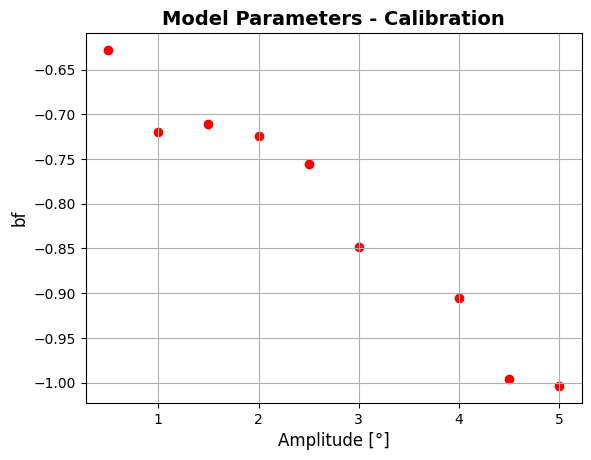

In [26]:
plt.scatter(amplitudes, bf, color='red', label='ks', marker='o')

# Add labels and title
plt.xlabel('Amplitude [°]',fontsize=12)
plt.ylabel('bf',fontsize=12)
plt.title('Model Parameters - Calibration',fontsize=14,fontweight='bold')

# Add grid
plt.grid(True)

# Display the plot
plt.show()


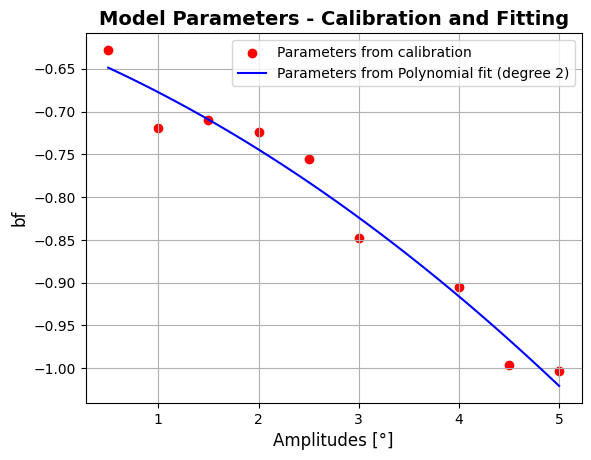

In [27]:
# Fit a polynomial of degree n (e.g., n=2 for a quadratic fit)
x=amplitudes
y=bf

degree = 2
coefficients_bf = np.polyfit(x, y, degree)
np.savetxt('coefficients_bf.txt',coefficients_bf)
# Define the interpolation function
def polynomial_function(coefficients_bf, x):
    degree = len(coefficients_bf) - 1
    f = sum(coef * x**(degree - i) for i, coef in enumerate(coefficients_bf))
    return f

# Generate x values for interpolation
x_interpolated_bf = np.linspace(min(x), max(x), 100)
y_interpolated_bf = polynomial_function(coefficients_bf, x_interpolated_bf)

# Plot the original data points
plt.scatter(x, y, color='red', label='Parameters from calibration')

# Plot the polynomial fit
plt.plot(x_interpolated_bf, y_interpolated_bf, color='blue', label=f'Parameters from Polynomial fit (degree {degree})')

# Add labels and legend
plt.xlabel('Amplitudes [°]',fontsize=12)
plt.ylabel('bf',fontsize=12)
plt.legend()
plt.title('Model Parameters - Calibration and Fitting',fontsize=14,fontweight='bold')
plt.grid(True)
output_path = r'C:\Users\asus\Desktop\Delft\THESIS\REPORT\IMAGES REPORT\7_bf_fit.png'
plt.savefig(output_path, bbox_inches='tight')
plt.show()

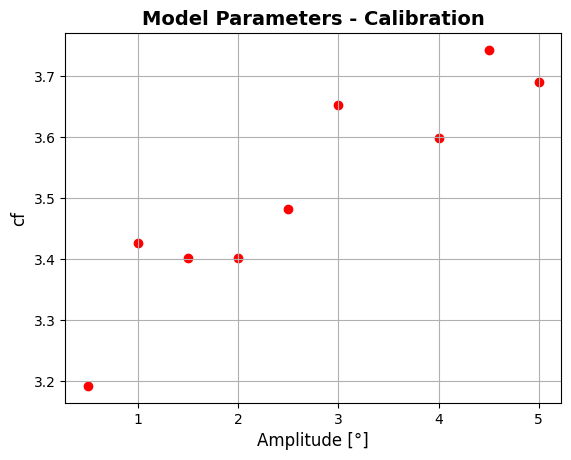

In [28]:
plt.scatter(amplitudes, cf, color='red', label='ks', marker='o')

# Add labels and title
plt.xlabel('Amplitude [°]',fontsize=12)
plt.ylabel('cf',fontsize=12)
plt.title('Model Parameters - Calibration',fontsize=14,fontweight='bold')

# Add grid
plt.grid(True)

# Display the plot
plt.show()


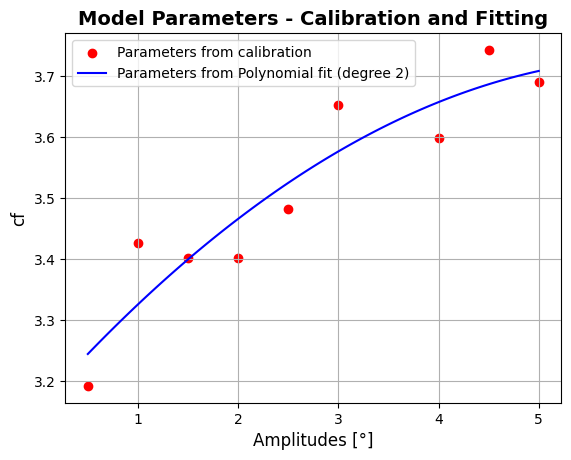

In [29]:
# Fit a polynomial of degree n (e.g., n=2 for a quadratic fit)
x=amplitudes
y=cf

degree = 2
coefficients_cf = np.polyfit(x, y, degree)
np.savetxt('coefficients_cf.txt',coefficients_cf)
# Define the interpolation function
def polynomial_function(coefficients_cf, x):
    degree = len(coefficients_cf) - 1
    f = sum(coef * x**(degree - i) for i, coef in enumerate(coefficients_cf))
    return f

# Generate x values for interpolation
x_interpolated_cf = np.linspace(min(x), max(x), 100)
y_interpolated_cf = polynomial_function(coefficients_cf, x_interpolated_cf)
# Plot the original data points
plt.scatter(x, y, color='red', label='Parameters from calibration')

# Plot the polynomial fit
plt.plot(x_interpolated_cf, y_interpolated_cf, color='blue', label=f'Parameters from Polynomial fit (degree {degree})')

# Add labels and legend
plt.xlabel('Amplitudes [°]',fontsize=12)
plt.ylabel('cf',fontsize=12)
plt.legend()
plt.title('Model Parameters - Calibration and Fitting',fontsize=14,fontweight='bold')
plt.grid(True)
output_path = r'C:\Users\asus\Desktop\Delft\THESIS\REPORT\IMAGES REPORT\7_cf_fit.png'
plt.savefig(output_path, bbox_inches='tight')
plt.show()


In [30]:
#test if the fit produced computational problems ( outside boundaries)
for helix_angle in np.linspace(0.5, 5, 200):
    bs1 = polynomial_function(coefficients_bs, x=helix_angle)
    cs1 = polynomial_function(coefficients_cs, x=helix_angle)
    bf1 = polynomial_function(coefficients_bf, x=helix_angle)
    cf1 = polynomial_function(coefficients_cf, x=helix_angle)
    
    windturbine=create_wind_turbine(helix_angle,D,H)
    optimized_params_DE = [bs1, cs1, bf1, cf1]
    wf_model_optimized_DE = BlondelSuperGaussianDeficit2020(
        a_s=0,
        b_s=optimized_params_DE[0],
        c_s=optimized_params_DE[1],
        b_f=optimized_params_DE[2],
        c_f=optimized_params_DE[3]
    )
    
    velocity_final_DE_xy = get_velocity_field_xy(wf_model_optimized_DE,windTurbines=windturbine)
    
    if np.isnan(velocity_final_DE_xy).any():
        print(f"NaN detected at helix_angle: {helix_angle}")

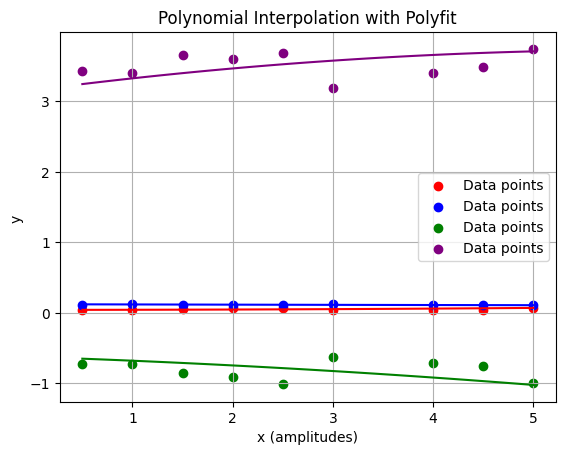

In [ ]:
# Plot the polynomial fit
x=amplitudes
plt.scatter(x, ks, color='red', label='Data points')
plt.scatter(x, cs, color='blue', label='Data points')
plt.scatter(x, bf, color='green', label='Data points')
plt.scatter(x, cf, color='purple', label='Data points')
plt.plot(x_interpolated_bs, y_interpolated_bs, color='red')
plt.plot(x_interpolated_cs, y_interpolated_cs, color='blue')
plt.plot(x_interpolated_bf, y_interpolated_bf, color='green')
plt.plot(x_interpolated_cf, y_interpolated_cf, color='purple')

# Add labels and legend
plt.xlabel('x (amplitudes)')
plt.ylabel('y ')
plt.legend()
plt.title('Polynomial Interpolation with Polyfit')
plt.grid(True)
plt.show()

[0.21306877577829111, 0.20034633069176544, 0.1926359369583482, 0.18242996993054292, 0.1876556248460218, 0.18295668133637616, 0.1921447118711835, 0.18303415046701949, 0.172946808477519]
[0.21311601175672065, 0.20103285721162065, 0.19248990900900897, 0.17807682812667278, 0.16726336366943903, 0.17194140882686795, 0.17873648683960824, 0.1679054814083157, 0.17251656204750396]


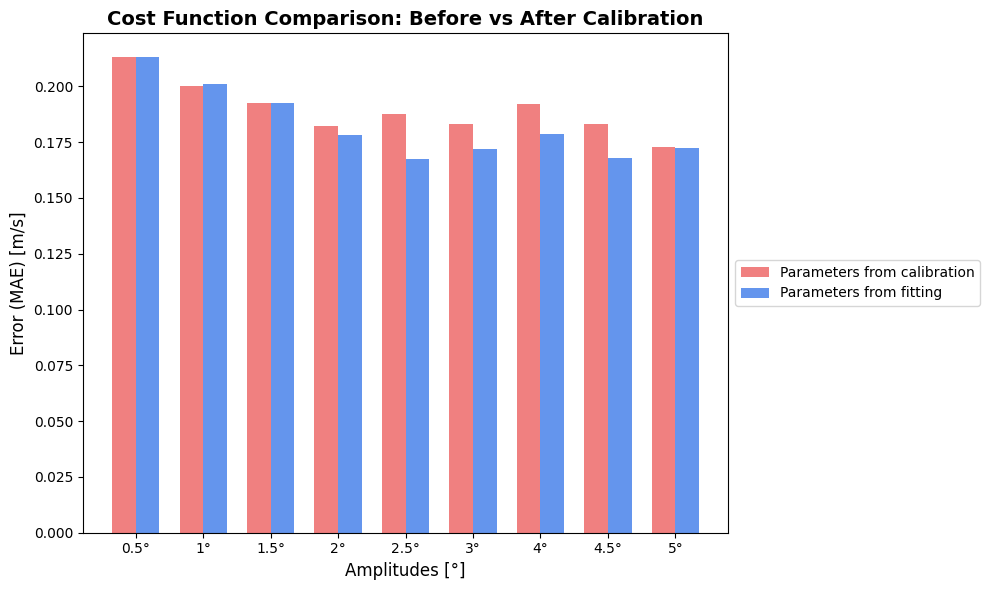

In [31]:
amplitudes = [0.5, 1, 1.5, 2, 2.5, 3, 4, 4.5, 5]

# Example params and sim_data for each amplitude (should be defined)
params_list = [
    optimized_params_05deg,
    optimized_params_1deg,
    optimized_params_2deg,
    optimized_params_3deg,
    optimized_params_4deg,
    optimized_params_5deg,
    optimized_params_15deg,
    optimized_params_25deg,
    optimized_params_45deg
]
sim05=np.loadtxt('107_helix_0.5deg_xy.1.txt')
sim1=np.loadtxt('102_helix_1deg_xy.1.txt')
sim15=np.loadtxt('108_helix_1.5deg_xy.1.txt')
sim2=np.loadtxt('103_helix_2deg_xy.1.txt')
sim25=np.loadtxt('109_helix_2.5deg_xy.1.txt')
sim3=np.loadtxt('104_helix_3deg_xy.1.txt')
sim4=np.loadtxt('105_helix_4deg_xy.1.txt')
sim45=np.loadtxt('111_helix_4.5deg_xy.1.txt')
sim5=np.loadtxt('106_helix_5deg_xy.1.txt')
sim_data_list = [
    sim05,
    sim1,
    sim15,
    sim2,
    sim25,
    sim3,
    sim4,
    sim45,
    sim5
]

# Define the x_tilde and x_tilde_matrix
x_tilde = 1 / D * np.linspace(0, 4400, 440)
x_tilde_matrix = np.tile(x_tilde, (280, 1))

# Define the objective function
def objective_function_xy(params, sim_data, windTurbines):
    b_s, c_s, b_f, c_f = params[0], params[1], params[2], params[3]
    a_s = 0
    model_cal = BlondelSuperGaussianDeficit2020(a_s=a_s, b_s=b_s, c_s=c_s, b_f=b_f, c_f=c_f)
    velocity_calibr_array = get_velocity_field_xy(model_cal, windTurbines=windTurbines).ravel()
    CT=get_ct(windTurbines, WS)
    beta = 0.5 * (1 + np.sqrt(1 - CT)) / (np.sqrt(1 - CT))
    sigma = (a_s * TI + b_s) * x_tilde_matrix.ravel() + c_s * np.sqrt(beta)
    n = 3.11 * np.exp(b_f * x_tilde) + c_f
    tot = np.average(abs(velocity_calibr_array - sim_data.ravel()))

    if math.isnan(tot):
        return 10**36
    else:
        if np.any(sigma < 0) or np.any(n < 2):
            return 10**36
        else:
            return tot

# Loop through each amplitude, params, and sim_data
results = []
results1 = []

for i, amplitude in enumerate(amplitudes):
    params = params_list[i]
    sim_data = sim_data_list[i]
    windTurbines = create_wind_turbine(amplitude, D, H)
    result = objective_function_xy(params, sim_data, windTurbines)
    results.append(result)

    bs1 = polynomial_function(coefficients_bs, x=amplitude)
    cs1 = polynomial_function(coefficients_cs, x=amplitude)
    bf1 = polynomial_function(coefficients_bf, x=amplitude)
    cf1 = polynomial_function(coefficients_cf, x=amplitude)
    params1=[bs1,cs1,bf1,cf1]
    simdata1=sim_data
    result1 = objective_function_xy(params1, simdata1, windTurbines)
    results1.append(result1)

print(results)
print(results1)


# Number of bars (should be equal to the length of results and results1)
n = len(amplitudes)

# Width of each bar
bar_width = 0.35

# Create an array of positions for the bars
index = np.arange(n)

# Increase figure size
fig, ax = plt.subplots(figsize=(10, 6))  # Adjust the numbers (width, height) as needed

# Color palette (choose any colors you like)
colors = ['lightcoral', 'cornflowerblue']

# Plot bars for results with the first color
bars1 = ax.bar(index, results, bar_width, label='Parameters from calibration', color=colors[0])

# Plot bars for results1 with the second color and slight offset for separation
bars2 = ax.bar(index + bar_width, results1, bar_width, label='Parameters from fitting', color=colors[1])

# Add labels, title, and legend
ax.set_xlabel('Amplitudes [°]',fontsize=12)
ax.set_ylabel('Error (MAE) [m/s]',fontsize=12)
ax.set_title('Cost Function Comparison: Before vs After Calibration', fontsize=14, fontweight='bold')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels([f'{amp}°' for amp in amplitudes])

# Place legend outside the plot
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Display the plot
plt.tight_layout()
output_path = r'C:\Users\asus\Desktop\Delft\THESIS\REPORT\IMAGES REPORT\7_CostFunction.png'
plt.savefig(output_path, bbox_inches='tight')
plt.show()